# EDA gc data


## Data loading


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from features import candle_feat

import warnings
warnings.filterwarnings('ignore')


In [31]:
## Load yfinance Gold data
yf = False

if yf:
  import yfinance as yf
  # Define the ticker symbol
  tickerSymbol = 'GC=F'
  # Get the data for this ticker
  tickerData = yf.Ticker(tickerSymbol)
  # Get the historical prices for this ticker
  data = tickerData.history(period='1d', start='2012-7-12')
else:
  data = pd.read_csv('gc_data_2012_2023_tradingview.csv')

In [32]:
data

,time,open,high,low,close
0,2011-04-17T22:00:00Z,1488.0,1498.6,1477.8,1492.9
1,2011-04-18T22:00:00Z,1496.6,1500.5,1488.2,1495.1
2,2011-04-19T22:00:00Z,1496.1,1506.5,1493.8,1498.9
3,2011-04-20T22:00:00Z,1502.0,1509.6,1500.4,1503.8
4,2011-04-24T22:00:00Z,1510.7,1519.2,1502.2,1509.1
...,...,...,...,...,...
3090,2023-07-25T22:00:00Z,1966.3,1979.9,1963.2,1970.1
3091,2023-07-26T22:00:00Z,1973.3,1982.6,1941.7,1945.7
3092,2023-07-27T22:00:00Z,1985.3,2002.0,1983.9,1999.9
3093,2023-07-30T22:00:00Z,1997.9,2010.9,1986.7,2009.2


## Check GPU


In [33]:
data['Date'] = data['time']
data['Date'] = pd.to_datetime(data['Date'])
data.drop(['time'], axis=1, inplace=True)
data.set_index('Date', inplace=True)
data = data.loc['07-12-2012':]
data.columns = ['Open', 'High', 'Low', 'Close']

data = data.dropna()
data = data.sort_values(by="Date", ascending=True)
#data.columns = ['Date','Open', 'High', 'Low', 'Close']


## Plotting the market data


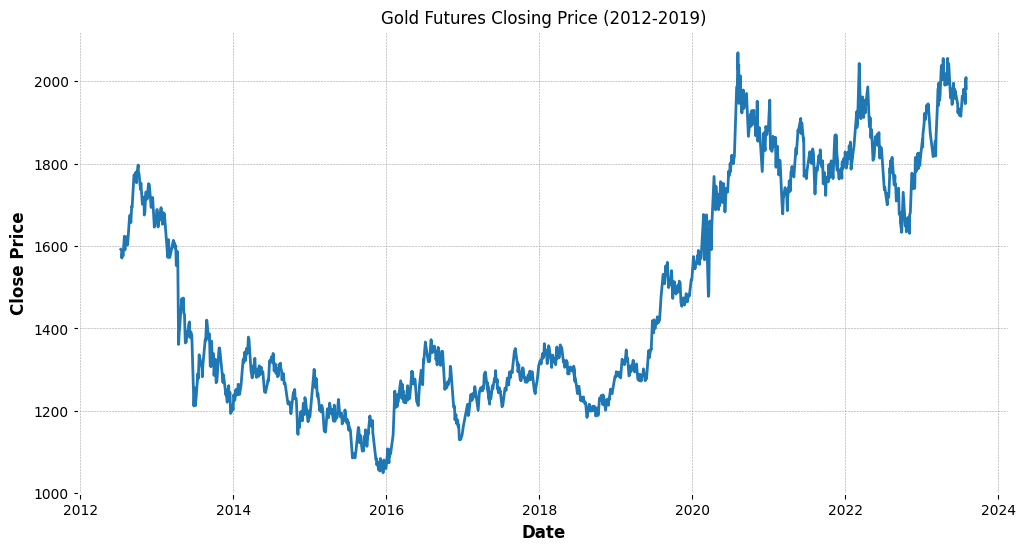

In [34]:
# Plotting
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('Gold Futures Closing Price (2012-2019)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [35]:
data_raw = data.copy()

In [36]:
data_raw.head()

,Open,High,Low,Close
Date,,,,
2012-07-12 22:00:00+00:00,1571.2,1596.5,1565.6,1592.0
2012-07-15 22:00:00+00:00,1591.5,1594.6,1577.2,1591.6
2012-07-16 22:00:00+00:00,1588.6,1598.8,1571.0,1589.5
2012-07-17 22:00:00+00:00,1583.0,1585.7,1567.2,1570.8
2012-07-18 22:00:00+00:00,1573.0,1591.5,1572.1,1580.4


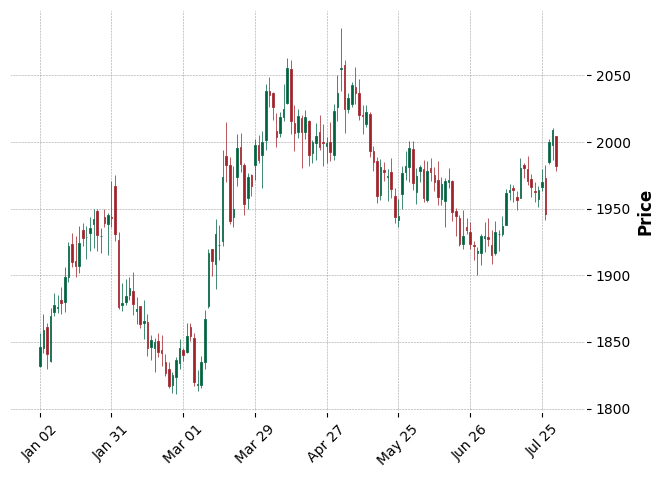

In [37]:
import mplfinance as mpf
mpf.plot(data.loc['01-01-2023':],type='candle', style='charles')

In [38]:
#data_raw.to_csv("gc_data_2012_2023Jul.csv")

## Defining the features


In [40]:
data.tail()

,Open,High,Low,Close
Date,,,,
2023-07-25 22:00:00+00:00,1966.3,1979.9,1963.2,1970.1
2023-07-26 22:00:00+00:00,1973.3,1982.6,1941.7,1945.7
2023-07-27 22:00:00+00:00,1985.3,2002.0,1983.9,1999.9
2023-07-30 22:00:00+00:00,1997.9,2010.9,1986.7,2009.2
2023-07-31 22:00:00+00:00,2004.2,2004.4,1978.3,1982.3


### other features


## Train and test set


In [41]:
drop_feature_list = ['Open','High','Low','Close','candleNextDay','returnNextDay','returnToday',
                       'candlelag_3', 'candlelag_4','candlelag_5', 'candlelag_6', 'CloseTomaFast_3',  'CloseTomaFast_4',
                      
                        #'MaFastMinusMa2Slow'
                       ]

#normalise features
feature_list = ['MaFastMinusMaSlow', 'MaFastMinusMa2Slow', 'MaSlowMinusMa2Slow',
                  'closeMinusMaFast', 'closeMinusMaSlow', 'close1MinusMaFast',
                  'close1MinusMaSlow']

def train_validate(data = data, tsplit=1000, estimators=1000, fast=7, slow=21, twoslow=35):

  #Generate features
  data = featurize(data, fast, slow, twoslow)
  data = data.dropna()

  #Define the training set
  X = data.drop(drop_feature_list, axis = 1)
  Y = data.candleNextDay
  returns = data.returnNextDay
  X.tail(5)

  #train_test split - temporal split
  tsplit = 2500
  XTrain = X[:tsplit]
  YTrain = Y[:tsplit]
  returnsTrain = returns[:tsplit]

  #Normalize
  for feature in feature_list:
    if feature in XTrain.columns:
      minmaxsc_1 = MinMaxScaler()
      XTrain[feature] = minmaxsc_1.fit_transform(XTrain[feature].values.reshape(-1,1))
    else:
      pass


  return XTrain, YTrain


In [42]:
train = train_validate(data_raw, 2500, 7, 21, 35)

In [43]:
train

(                           closeMinusMaFast  close1MinusMaFast  \
 Date                                                             
 2012-07-23 22:00:00+00:00          0.542423           0.540291   
 2012-07-24 22:00:00+00:00          0.630164           0.530256   
 2012-07-25 22:00:00+00:00          0.643562           0.623448   
 2012-07-26 22:00:00+00:00          0.644814           0.637764   
 2012-07-29 22:00:00+00:00          0.654215           0.638101   
 ...                                     ...                ...   
 2022-06-16 22:00:00+00:00          0.551746           0.575960   
 2022-06-19 22:00:00+00:00          0.548818           0.549085   
 2022-06-21 22:00:00+00:00          0.549888           0.545812   
 2022-06-22 22:00:00+00:00          0.529005           0.549219   
 2022-06-23 22:00:00+00:00          0.534275           0.526126   
 
                            closeMinusMaSlow  MaFastMinusMaSlow  \
 Date                                                       